In [1]:
import matplotlib.pyplot as plt
import numpy as np

from utilities import get_tex_label, get_color, latex_text_width_1col
from hazma.gamma_ray_parameters import energy_res_comptel
from hazma.scalar_mediator import HiggsPortal, HeavyQuark

**Plots annihilation spectra for the scalar model in the case $m_\chi < m_S$.**

In [7]:
# Dark matter masses
mxs = np.array([100.0, 110.0, 140.0, 250.0])
# Mediator mass
ms = 1e3
# List of models. The top row of the plot will contain the Higgs portal model
# spectra, the bottom the heavy quark model spectra.
sms = [
    HiggsPortal(1.0, ms, gsxx=1.0, stheta=1e-1),
    HeavyQuark(1.0, ms, gsxx=1.0, gsQ=1e-1, mQ=1e3, QQ=1.0),
]

# Approximate Milky Way velocity dispersion, used to compute the DM
# center of mass energy
vx_mw = 1e-3

# Photon energies
e_gam_min, e_gam_max = 5.0, 300.0
e_gams = np.geomspace(e_gam_min, e_gam_max, 250)

# Plot dimensions
n_subplot_rows, n_subplot_cols = len(sms), len(mxs)
# Final state labels for each subplot
fs_labels = np.array(
    [
        [
            {"e e": (1.5e1, 4e-3)},
            {"mu mu": (1.5e1, 3e-3)},
            {"pi pi": (7e0, 4e-3), "pi0 pi0": (4.5e1, 9e-2)},
            {},
        ],
        [{}, {}, {"pi pi": (7e0, 4e-3), "pi0 pi0": (4.5e1, 1.1e-1)}, {}],
    ]
)

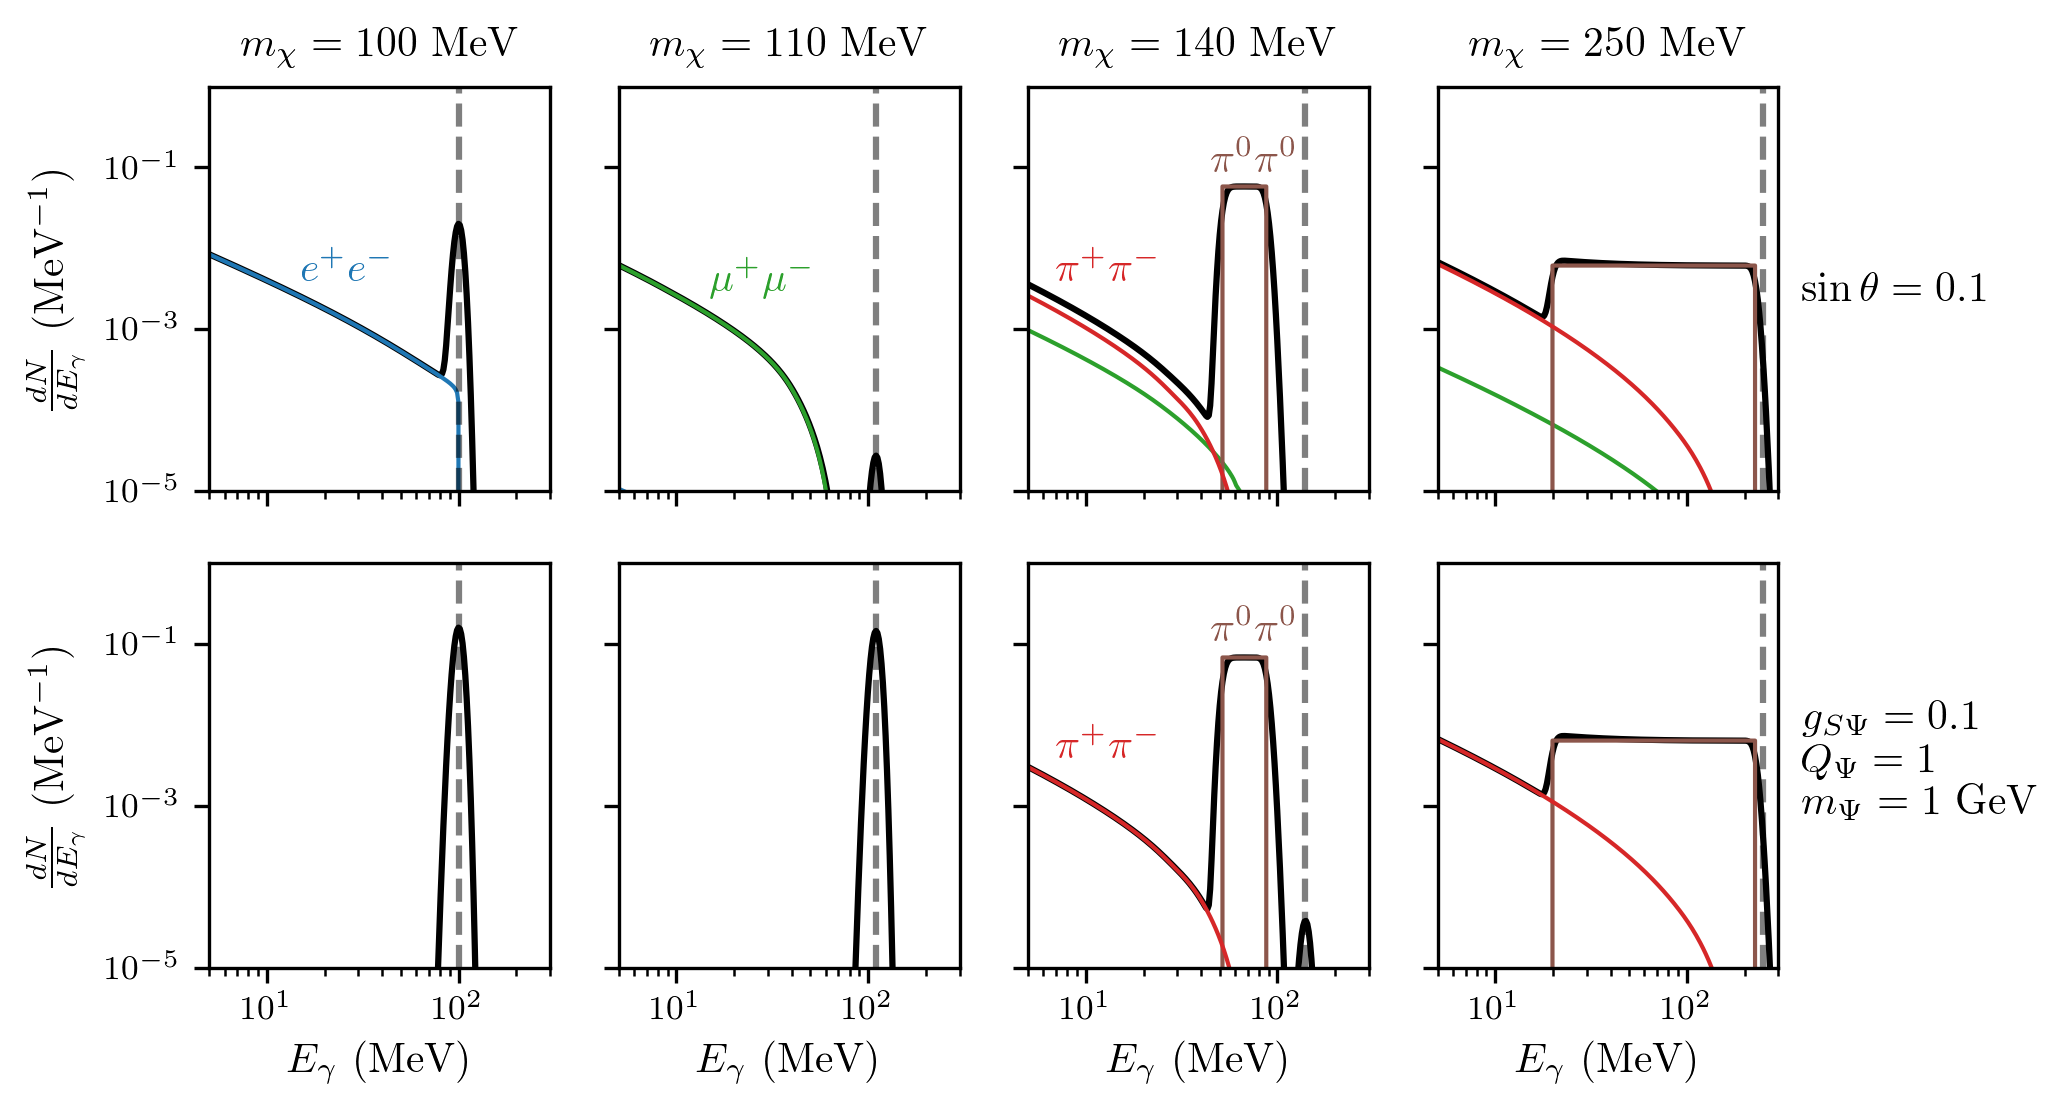

In [8]:
fig, axes = plt.subplots(
    n_subplot_rows,
    n_subplot_cols,
    sharex=True,
    sharey=True,
    figsize=(latex_text_width_1col, 0.55 * latex_text_width_1col),
)

for row in range(n_subplot_rows):  # loop over type of model
    for col in range(n_subplot_cols):  # loop over DM masses
        ax = axes[row, col]

        # Get the model and set DM mass to column's value
        sm = sms[row]
        sm.mx = mxs[col]
        # DM center of mass energy
        e_cm = 2.0 * sm.mx * (1.0 + 0.5 * vx_mw ** 2)

        # Get function to compute total convolved spectrum
        dnde_det_fn = sm.total_conv_spectrum_fn(
            e_gam_min, e_gam_max, e_cm, energy_res=energy_res_comptel
        )
        # Evaluate and plot
        ax.loglog(e_gams, dnde_det_fn(e_gams), "k")

        # Plot individual channels' continuum spectra
        for fs, spec in sm.spectra(e_gams, e_cm).items():
            if fs != "total":
                ax.loglog(e_gams, spec, color=get_color(fs), linewidth=1)

        # Compute line energies
        for fs, line_info in sm.gamma_ray_lines(e_cm).items():
            ax.axvline(
                line_info["energy"],
                linestyle="--",
                color="k",
                alpha=0.5,
                linewidth=1.5,
                label=r"$E_{\gamma\gamma}$",
            )

        # Formatting: label final states
        for fs, (x, y) in fs_labels[row, col].items():
            ax.text(x, y, get_tex_label(fs), fontsize=10, color=get_color(fs))

# Formatting
for row in range(n_subplot_rows):
    axes[row, 0].set_ylabel(r"$\frac{dN}{dE_\gamma}$ (MeV$^{-1}$)")
    axes[row, 0].set_ylim(1e-5, 1e0)

for col in range(n_subplot_cols):
    axes[0, col].set_title(r"$m_\chi = %i$ MeV" % mxs[col], fontsize=10)
    axes[-1, col].set_xlabel(r"$E_\gamma$ (MeV)")
    axes[-1, col].set_xlim(e_gam_min, e_gam_max)

axes[0, -1].text(400, 3e-3, r"$\sin\theta = 0.1$", va="center", fontsize=10)
axes[1, -1].text(
    400,
    3e-3,
    r"$g_{S\Psi} = 0.1$" + "\n" + r"$Q_\Psi = 1$" + "\n" + r"$m_\Psi = 1$ GeV",
    va="center",
    fontsize=10,
)

fig.tight_layout()
fig.savefig("figures/scalar_spectra_ann_to_sm.pdf", bbox_inches="tight")
plt.show()